## Contents:
1. Find best epoch from each CV cycle with `find_best_model`
2. Calculate old results from Anthony's runs
3. Calculate and plot best metrics from `aidan_test.py`

### Find Best Metrics

Loops through each set of 15 epochs for all the cross validation cycles and finds the combination of epochs with the best results given a set of metrics and weights for their importance

In [86]:
import os
import re
import glob
import numpy as np

In [90]:
# Change path to your diagnostic folder here
diagnostics_folder = os.path.join(os.getcwd(),'diagnostic_save_path')
metrics = ['accuracy', 'auc']
weights = {'accuracy': 0.5, 'auc': 0.5}

In [100]:

def extract_metrics(file_path, required_metrics):
    """
    Extract specified metrics from a diagnostic file.
    
    `param file_path`: Path to the diagnostic file
    `param required_metrics`: List of metrics to extract
    `return`: A dictionary with the extracted metrics
    """
    metrics = {}
    with open(file_path, 'r') as file:
        content = file.read()
    
    metric_patterns = {
        'precision': r'Precision:\s+(\d\.\d+)',
        'recall': r'Recall:\s+(\d\.\d+)',
        'f1_score': r'F1 Score:\s+(\d\.\d+)',
        'accuracy': r'Accuracy:\s+(\d\.\d+)',
        'auc': r'AUC:\s+(\d\.\d+)'
    }
    
    for metric in required_metrics:
        if metric in metric_patterns:
            match = re.search(metric_patterns[metric], content)
            if match:
                metrics[metric] = float(match.group(1))
    
    return metrics

def calculate_weighted_average(metrics, weights):
    """
    Calculate the weighted average of the metrics.
    
    `param metrics`: Dictionary of metrics
    `param weights`: Dictionary of weights for each metric
    `return`: Weighted average score
    """
    weighted_sum = 0
    total_weight = sum(weights.values())
    
    for metric, weight in weights.items():
        if metric in metrics:
            weighted_sum += metrics[metric] * weight
    
    return weighted_sum / total_weight if total_weight > 0 else 0

def average_metrics(metrics_list):
    """
    Calculate the average of each metric across all dictionaries in the list.
    
    :param metrics_list: List of dictionaries containing metrics
    :return: Dictionary with averaged metrics
    """
    if not metrics_list:
        return {}

    # Initialize a dictionary to store the sum of each metric
    sum_metrics = {}
    
    # Sum up all the metrics
    for metrics in metrics_list:
        for key, value in metrics.items():
            if key not in sum_metrics:
                sum_metrics[key] = 0
            sum_metrics[key] += value
    
    # Calculate the average for each metric
    avg_metrics = {key: value / len(metrics_list) for key, value in sum_metrics.items()}
    
    return avg_metrics

def find_best_model(diagnostics_folder, metrics, weights):
    """
    Find the best model based on a weighted average of metrics.
    
    `param diagnostics_folder`: Folder containing the diagnostic files
    `param metrics`: List of metrics to consider
    `param weights`: Dictionary of weights for each metric
    `return`: The best model's diagnostic file and its weighted average score
    """
    diagnostic_files = sorted(glob.glob(os.path.join(diagnostics_folder, 'diagnostics_*.txt')))
    cross_validation_groups = [diagnostic_files[i:i+15] for i in range(0, len(diagnostic_files), 15)]
    
    best_scores = []
    best_metrics_averages = []
    best_files = []
    
    for i, group in enumerate(cross_validation_groups):
        group_best_score = -np.inf
        group_best_metrics = None
        group_best_file = None
        
        for file in group:
            metrics_data = extract_metrics(file, metrics)
            score = calculate_weighted_average(metrics_data, weights)
            
            if score > group_best_score:
                group_best_score = score
                group_best_metrics = metrics_data
                group_best_file = file

        best_scores.append(group_best_score)
        best_metrics_averages.append(group_best_metrics)
        best_files.append(group_best_file)
        print(f"Group {i+1} best metrics: {group_best_metrics}")

    average_best_score = np.average(best_scores)
    best_metrics_averages = average_metrics(best_metrics_averages)

    return best_files, average_best_score, best_metrics_averages

In [101]:
best_model, best_score, best_metric_averages = find_best_model(diagnostics_folder, metrics, weights)
print(f"Best model files: {best_model}")
print(f"Best model score: {best_score}")
print(f"Best model metrics averages: {best_metric_averages}")

Group 1 best metrics: {'accuracy': 0.9469, 'auc': 0.989}
Group 2 best metrics: {'accuracy': 0.9437, 'auc': 0.9801}
Group 3 best metrics: {'accuracy': 0.9375, 'auc': 0.9878}
Group 4 best metrics: {'accuracy': 0.9344, 'auc': 0.9767}
Best model files: ['c:\\Users\\u251245\\CVEpilepsy_remote\\diagnostic_save_path\\diagnostics_20240711_141937.txt', 'c:\\Users\\u251245\\CVEpilepsy_remote\\diagnostic_save_path\\diagnostics_20240711_144627.txt', 'c:\\Users\\u251245\\CVEpilepsy_remote\\diagnostic_save_path\\diagnostics_20240711_151814.txt', 'c:\\Users\\u251245\\CVEpilepsy_remote\\diagnostic_save_path\\diagnostics_20240711_155105.txt']
Best model score: 0.9620125
Best model metrics averages: {'accuracy': 0.940625, 'auc': 0.9834}


In [93]:
for model in best_model:
    print(model)

c:\Users\u251245\CVEpilepsy_remote\diagnostic_save_path\diagnostics_20240711_141937.txt
c:\Users\u251245\CVEpilepsy_remote\diagnostic_save_path\diagnostics_20240711_144627.txt
c:\Users\u251245\CVEpilepsy_remote\diagnostic_save_path\diagnostics_20240711_151814.txt
c:\Users\u251245\CVEpilepsy_remote\diagnostic_save_path\diagnostics_20240711_155105.txt


#### Calculate Anthony's Results

In [94]:
def calculate_metrics_averages(file_path):
    """
    Calculate the averages of all metrics found in a text file.
    
    :param file_path: Path to the text file containing the metrics
    :return: A dictionary with the average values of each metric
    """
    metrics_sum = {}
    metrics_count = {}

    with open(file_path, 'r') as file:
        content = file.read()
    
    # Regular expression to find all metrics
    pattern = re.compile(r'(\w+(?: \w+)*):\s+(\d\.\d+)')
    matches = pattern.findall(content)
    
    for match in matches:
        metric_name = match[0].replace(' ', '_')  # Replace spaces with underscores for consistency
        metric_value = float(match[1])
        
        if metric_name in metrics_sum:
            metrics_sum[metric_name] += metric_value
            metrics_count[metric_name] += 1
        else:
            metrics_sum[metric_name] = metric_value
            metrics_count[metric_name] = 1
    
    # Calculate averages
    metrics_averages = {metric: metrics_sum[metric] / metrics_count[metric] for metric in metrics_sum}
    
    return metrics_averages


In [95]:
file_path_uncropped = 'C:/Users/u251245/CVEpilepsy/anthony_results_i3d_uncropped.txt'
file_path_cropped = 'C:/Users/u251245/CVEpilepsy/anthony_results_i3d_cropped.txt'
averages_uc = calculate_metrics_averages(file_path_uncropped)
averages_c = calculate_metrics_averages(file_path_cropped)
print(f'Uncropped Averages:\n{averages_uc}\n')
print(f'Cropped Averages:\n{averages_c}')

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/u251245/CVEpilepsy/anthony_results_i3d_uncropped.txt'

### Calculate Test Metrics

In [110]:
def get_diagnostic_files(save_dir:str=os.path.join(os.getcwd(),'diagnostic_save_path')):
    results = []
    for r, d, files in os.walk(save_dir):
        for file in files:
            if file.endswith(".txt"):
                results.append(os.path.join(r,file))
    return results

file_paths = get_diagnostic_files()
print(file_paths)

['c:\\Users\\u251245\\CVEpilepsy_remote\\diagnostic_save_path\\diagnostics_20240711_170753.txt', 'c:\\Users\\u251245\\CVEpilepsy_remote\\diagnostic_save_path\\diagnostics_20240711_170815.txt', 'c:\\Users\\u251245\\CVEpilepsy_remote\\diagnostic_save_path\\diagnostics_20240711_170848.txt', 'c:\\Users\\u251245\\CVEpilepsy_remote\\diagnostic_save_path\\diagnostics_20240711_170915.txt', 'c:\\Users\\u251245\\CVEpilepsy_remote\\diagnostic_save_path\\diagnostics_20240711_170935.txt', 'c:\\Users\\u251245\\CVEpilepsy_remote\\diagnostic_save_path\\diagnostics_20240711_171003.txt', 'c:\\Users\\u251245\\CVEpilepsy_remote\\diagnostic_save_path\\diagnostics_20240711_171018.txt', 'c:\\Users\\u251245\\CVEpilepsy_remote\\diagnostic_save_path\\diagnostics_20240711_171037.txt', 'c:\\Users\\u251245\\CVEpilepsy_remote\\diagnostic_save_path\\diagnostics_20240711_171051.txt', 'c:\\Users\\u251245\\CVEpilepsy_remote\\diagnostic_save_path\\diagnostics_20240711_171142.txt', 'c:\\Users\\u251245\\CVEpilepsy_remote\

In [111]:
req_metrics = ['accuracy', 'auc']
results = []
video_names_ordered = []
for _,_,videos in os.walk(os.path.join(os.getcwd(), 'annotations', 'video_test_annotations')):
    for video in videos:
        video_names_ordered.append(video.strip('.txt'))
for i, file in enumerate(get_diagnostic_files(save_dir=os.path.join(os.getcwd(),'diagnostic_save_path'))):
    output = extract_metrics(file, req_metrics)
    output['video'] = video_names_ordered[i]
    results.append(output)

In [112]:
videos = [entry['video'] for entry in results]
print(videos)

['00105B00', '00105C00', '00108500', '00108700', '00200100', '00200200', '22200Q01', '22200S00', '22200T00', '77952GP00', '7913ZY00', '7940HO00', '7940HU00', '7940K700', '79410R00', '7941CO00', '7941D100', '7941D200', '7941D300', '7941D400', '7941D500', '7941D600', '7941E901', '7941EA00', '7941EC00', '7941LY00', '7941M700', '7942GT00', '7942GU00', '7942GZ00', '7942QQ00', '7942QR00', '79519000', '7951EX00', '7952DG00', '7952DP00', '7953A100', '7953A400', '7962TA00', '7964JU00', '7970IA00', '79719R00', '7971C500', '7971C700', '7971H000', '7971Q500', '7971UI00', '7972M300', '7972OT00']


### Plot test metrics

Average accuracy TEST: 0.947
Average AUC TEST: 0.988



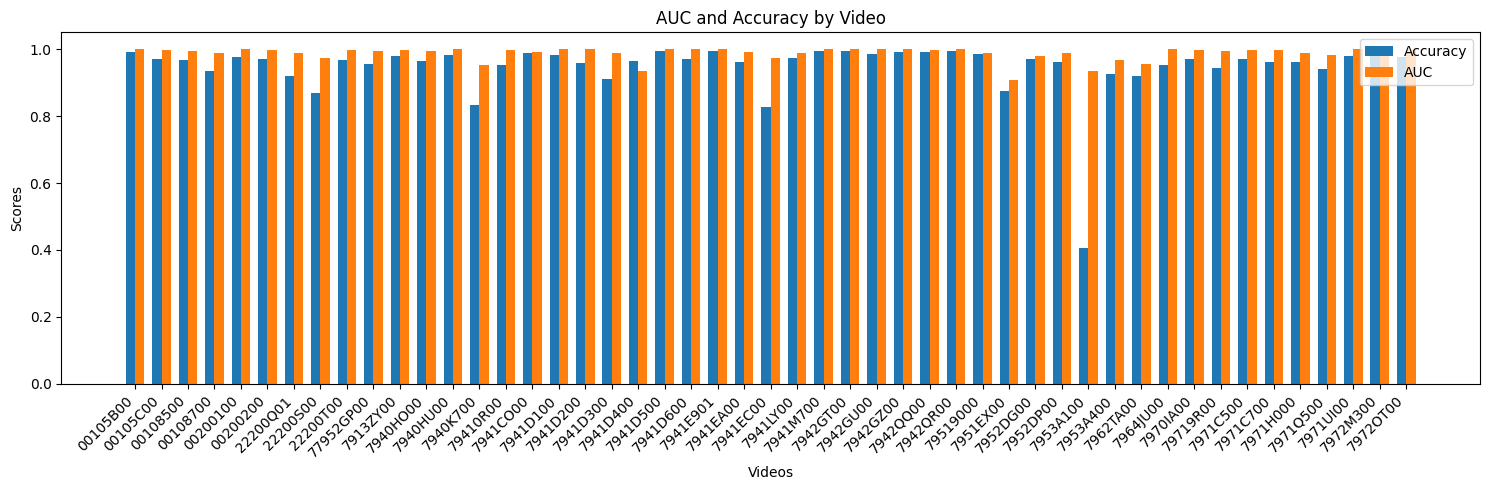

In [113]:
import matplotlib.pyplot as plt
import numpy as np

def plot_metrics(data):
    videos = [entry['video'] for entry in data]
    accuracies = [entry['accuracy'] for entry in data]
    aucs = [entry['auc'] for entry in data]
    print(f"Average accuracy TEST: {np.mean(accuracies):.3f}\nAverage AUC TEST: {np.mean(aucs):.3f}\n")

    x = np.arange(len(videos))  # the label locations
    width = 0.35  # the width of the bars
    fig, ax = plt.subplots(figsize=(15,5))
    rects1 = ax.bar(x - width/2, accuracies, width, label='Accuracy')
    rects2 = ax.bar(x + width/2, aucs, width, label='AUC')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel('Videos')
    ax.set_ylabel('Scores')
    ax.set_title('AUC and Accuracy by Video')
    ax.set_xticks(x)
    ax.set_xticklabels(videos)
    ax.legend()

    # Rotate the video labels to fit them better
    plt.xticks(rotation=45, ha="right")

    fig.tight_layout()

    plt.show()

plot_metrics(results)
